# 01: Purification of Chaos - Visual Convergence

**Theme:** ノイズに埋もれた数字が、思考ステップを経るごとに鮮明な概念（不動点）に変わっていく様を可視化します。

## What You'll See

1. **Image Evolution**: 各Vicaraステップで潜在状態をデコードし、ノイズ画像が徐々にクリアになる過程
2. **Latent Space Trajectory**: PCAで潜在空間を可視化し、点がアトラクタに吸い寄せられる軌跡

---

## Architecture Overview

```mermaid
flowchart TB
    subgraph Input
        X["Noisy Image (X)"]
    end

    subgraph Samatha["SamathaEngine (収束エンジン)"]
        Adapter["CnnAdapter"]
        Augmenter["GaussianAugmenter"]
        Vitakka["Vitakka (意図的初期化)"]
        Vicara["Vicara Loop (収束的洗練)<br/>s₁ → s₂ → ... → s*"]
        Santana["SantanaLog (軌跡記録)"]
        
        Adapter --> Augmenter --> Vitakka
        Vitakka -->|"s₀"| Vicara
        Vicara --> Santana
    end

    subgraph Output
        Decoder["CnnDecoder"]
        Result["Reconstructed Images"]
    end

    X --> Adapter
    Santana -->|"S*"| Decoder
    Decoder --> Result
```

## 1. Setup & Imports

In [1]:
# Satipatthana Framework Setup
# 1. ログ設定は必ず最初に行う
from satipatthana.utils.logger import setup_logging
setup_logging()

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from transformers import TrainingArguments
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# Core System
from satipatthana.core.system import SatipatthanaSystem, TrainingStage
from satipatthana.core.engines import SamathaEngine, VipassanaEngine

# Configs
from satipatthana.configs.system import SystemConfig, SamathaConfig, VipassanaEngineConfig
from satipatthana.configs.adapters import CnnAdapterConfig
from satipatthana.configs.decoders import CnnDecoderConfig, ConditionalDecoderConfig
from satipatthana.configs.vitakka import StandardVitakkaConfig
from satipatthana.configs.vicara import StandardVicaraConfig
from satipatthana.configs.vipassana import StandardVipassanaConfig
from satipatthana.configs.augmenter import GaussianNoiseAugmenterConfig
from satipatthana.configs.sati import FixedStepSatiConfig

# Components
from satipatthana.components.adapters.vision import CnnAdapter
from satipatthana.components.decoders.vision import CnnDecoder
from satipatthana.components.decoders.conditional import ConditionalDecoder
from satipatthana.components.vitakka.standard import StandardVitakka
from satipatthana.components.vicara.standard import StandardVicara
from satipatthana.components.refiners.mlp import MlpRefiner
from satipatthana.components.vipassana.standard import StandardVipassana
from satipatthana.components.augmenters.gaussian import GaussianNoiseAugmenter
from satipatthana.components.sati.fixed_step import FixedStepSati

# Trainer
from satipatthana.train.trainer import SatipatthanaTrainer

# Device configuration
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using device: {device}")

/Users/ryota.ido/mine/samadhi_model/.venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: mps


## 2. Configuration

**Key Settings for this demo:**
- `max_steps=10`: 思考の刻みを細かくして軌跡を可視化
- `GaussianNoiseAugmenter`: 推論時に強いノイズを加える
- `CnnDecoder`: 各ステップの潜在状態を画像にデコード

In [2]:
# ========================================
# Global Parameters
# ========================================
DIM = 128           # Latent dimension (increased for better representation)
IMG_SIZE = 32       # Image size (must be divisible by 16 for CnnDecoder)
CHANNELS = 1        # Grayscale
N_PROBES = 10       # Number of concept probes (0-9 digits)
CONTEXT_DIM = 32    # Vipassana context vector dimension (scaled with DIM)
MAX_STEPS = 10      # Vicara refinement steps (細かく可視化するため多め)

# ========================================
# Component Configurations
# ========================================

# Adapter: Image (32x32) -> Latent Vector (dim=128)
adapter_config = CnnAdapterConfig(
    channels=CHANNELS,
    img_size=IMG_SIZE,
    dim=DIM,
    dropout=0.1
)

# Augmenter: Gaussian noise (推論時に強いノイズを加える)
augmenter_config = GaussianNoiseAugmenterConfig(
    max_noise_std=1.0  # 強めのノイズ設定
)

# Vitakka: Semantic initialization via prototype matching
vitakka_config = StandardVitakkaConfig(
    dim=DIM,
    n_probes=N_PROBES,
    probe_trainable=True,  # プローブも学習させる
    mix_alpha=0.3,
    softmax_temp=0.2,
    gate_threshold=-1.0
)

# Vicara: Convergent refinement
vicara_config = StandardVicaraConfig(
    dim=DIM,
    refine_steps=MAX_STEPS,
    inertia=0.5,  # Lower inertia for faster convergence
)

# Sati: Fixed step stopping
sati_config = FixedStepSatiConfig()

# Vipassana: Meta-cognition
vipassana_config = StandardVipassanaConfig(
    context_dim=CONTEXT_DIM,
    hidden_dim=128  # Scaled with DIM
)

# Task Decoder: S* + V_ctx -> Flattened Image
task_decoder_config = ConditionalDecoderConfig(
    dim=DIM,
    context_dim=CONTEXT_DIM,
    output_dim=IMG_SIZE * IMG_SIZE * CHANNELS,
    decoder_hidden_dim=512  # Increased for better reconstruction
)

# CNN Decoder: For reconstruction (latent -> image)
cnn_decoder_config = CnnDecoderConfig(
    dim=DIM,
    channels=CHANNELS,
    img_size=IMG_SIZE
)

print("Configuration created!")
print(f"  Latent Dim: {DIM}")
print(f"  Image Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"  Max Steps: {MAX_STEPS}")
print(f"  Inertia: {vicara_config.inertia}")
print(f"  Max Noise Std: {augmenter_config.max_noise_std}")
print(f"  Probe Trainable: {vitakka_config.probe_trainable}")

Configuration created!
  Latent Dim: 128
  Image Size: 32x32
  Max Steps: 10
  Inertia: 0.5
  Max Noise Std: 1.0
  Probe Trainable: True


## 3. Dataset

In [3]:
class MNISTDenoisingDataset(Dataset):
    """
    Dataset providing (noisy_image, clean_image) pairs for denoising task.

    Note: Noise is applied via Augmenter during training, not here.
    """
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        clean_img, label = self.mnist_dataset[idx]
        clean_flat = clean_img.view(-1)
        return {
            "x": clean_img,
            "y": clean_flat,
            "class_label": torch.tensor(label, dtype=torch.long)
        }


# Load MNIST
print("Loading MNIST data...")

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_mnist = datasets.MNIST("./data", train=True, download=True, transform=transform)
test_mnist = datasets.MNIST("./data", train=False, download=True, transform=transform)

train_dataset = MNISTDenoisingDataset(train_mnist)
test_dataset = MNISTDenoisingDataset(test_mnist)

print(f"  Train samples: {len(train_dataset)}")
print(f"  Test samples: {len(test_dataset)}")

Loading MNIST data...
  Train samples: 60000
  Test samples: 10000


## 4. Build System

In [4]:
def build_system():
    """Build complete SatipatthanaSystem for MNIST."""
    print("Building SatipatthanaSystem...")

    # Components
    adapter = CnnAdapter(adapter_config)
    augmenter = GaussianNoiseAugmenter(augmenter_config)
    vitakka = StandardVitakka(vitakka_config)
    refiner = MlpRefiner({"dim": DIM})
    vicara = StandardVicara(vicara_config, refiner=refiner)
    sati = FixedStepSati(sati_config)
    vipassana_module = StandardVipassana(vipassana_config)
    task_decoder = ConditionalDecoder(task_decoder_config)

    # Reconstruction Heads
    adapter_recon_head = CnnDecoder(cnn_decoder_config)
    samatha_recon_head = CnnDecoder(cnn_decoder_config)

    # Engine Configs
    samatha_config_obj = SamathaConfig(
        dim=DIM,
        max_steps=MAX_STEPS,
        adapter=adapter_config,
        augmenter=augmenter_config,
        vitakka=vitakka_config,
        vicara=vicara_config,
        sati=sati_config
    )

    vipassana_engine_config = VipassanaEngineConfig(
        vipassana=vipassana_config
    )

    system_config = SystemConfig(
        dim=DIM,
        seed=42,
        use_label_guidance=False,
        samatha=samatha_config_obj,
        vipassana=vipassana_engine_config,
        task_decoder=task_decoder_config
    )

    # Engines
    samatha_engine = SamathaEngine(
        config=samatha_config_obj,
        adapter=adapter,
        augmenter=augmenter,
        vitakka=vitakka,
        vicara=vicara,
        sati=sati
    )

    vipassana_engine = VipassanaEngine(
        config=vipassana_engine_config,
        vipassana=vipassana_module
    )

    # System
    system = SatipatthanaSystem(
        config=system_config,
        samatha=samatha_engine,
        vipassana=vipassana_engine,
        task_decoder=task_decoder,
        adapter_recon_head=adapter_recon_head,
        samatha_recon_head=samatha_recon_head
    )

    print("  SatipatthanaSystem built successfully!")
    return system


system = build_system()
system.to(device)
print(f"  Moved to device: {device}")

Building SatipatthanaSystem...
  SatipatthanaSystem built successfully!
  Moved to device: mps


## 5. Initialize Probes with Representative Digits

Initializing concept probes with representative digits...
  Probes initialized!


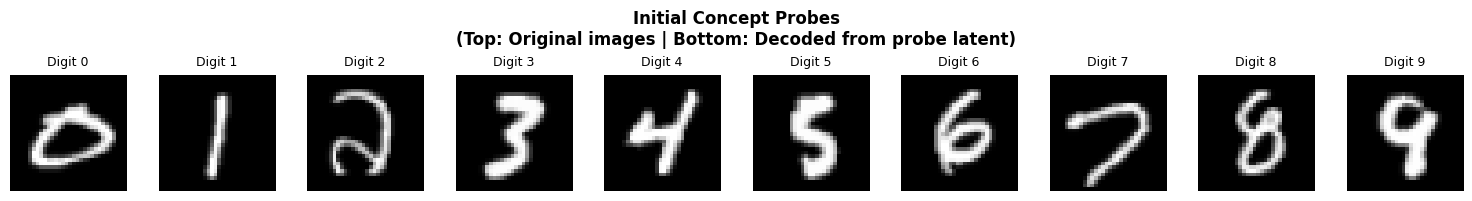

In [5]:
print("Initializing concept probes with representative digits...")

# Find one representative image per digit (0-9)
representative_images = [None] * N_PROBES
found = [False] * N_PROBES

for img, label in DataLoader(train_mnist, batch_size=1, shuffle=True):
    if label.item() < N_PROBES and not found[label.item()]:
        representative_images[label.item()] = img
        found[label.item()] = True
    if all(found):
        break

# Encode representative images to latent space
rep_batch = torch.cat(representative_images, dim=0).to(device)

system.eval()
with torch.no_grad():
    latent_probes = system.samatha.adapter(rep_batch)

# Initialize Vitakka probes
system.samatha.vitakka.probes.data = latent_probes.clone()
print("  Probes initialized!")

# Save initial probes for later comparison
initial_probes = latent_probes.clone()
initial_rep_images = rep_batch.clone()

# Visualize initial probes
with torch.no_grad():
    decoded_probes = system.samatha_recon_head(latent_probes)

fig, axes = plt.subplots(1, N_PROBES, figsize=(N_PROBES * 1.5, 2))

# Original representative images
for i in range(N_PROBES):
    axes[i].imshow(rep_batch[i].cpu().squeeze(), cmap="gray")
    axes[i].set_title(f"Digit {i}", fontsize=9)
    axes[i].axis("off")
axes[0].set_ylabel("Original", fontsize=10)

plt.suptitle("Initial Concept Probes\n(Top: Original images | Bottom: Decoded from probe latent)", fontweight='bold')
plt.tight_layout()
plt.show()

## 6. Samatha Training (Stage 0 + Stage 1)

Samathaの収束プロセスを学習します：
- **Stage 0**: Adapter Pre-training（画像→潜在空間の変換を学習）
- **Stage 1**: Samatha Training（収束する固定点 + samatha_recon_head を学習）

**Note:** このNotebookはSamathaの可視化が目的のため、Stage 2 (Vipassana) と Stage 3 (Decoder) はスキップします。

In [6]:
training_args = TrainingArguments(
    output_dir="./outputs/01_mnist_convergence",
    num_train_epochs=1,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    logging_steps=200,
    remove_unused_columns=False,
    label_names=["y", "class_label"],  # class_label も使用
    report_to="none",
    save_strategy="no",
)

trainer = SatipatthanaTrainer(
    model=system,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    stage=TrainingStage.ADAPTER_PRETRAINING,
    task_type="classification",  # 分類タスクとして設定
    use_label_guidance=False,     # ラベル誘導を有効化
    noise_level=0.3,
    stability_weight=0.1,
    guidance_weight=5.0,         # ラベル誘導の重み
    recon_weight=1.0,
    diversity_weight=0.5,        # プローブ分散
)

print("\n" + "="*60)
print("Samatha Training (Stage 0 + Stage 1)")
print("  - use_label_guidance=True: ラベルで収束先を誘導")
print("  - label_key='class_label': 分類ラベルを使用")
print("  - diversity_weight=0.5: プローブ間の分散を促進")
print("="*60)

# Stage 0: Adapter Pre-training (2 epochs)
print("\n--- Stage 0: Adapter Pre-training ---")
trainer.train_stage(TrainingStage.ADAPTER_PRETRAINING, num_epochs=2)

# Stage 1: Samatha Training (5 epochs)
print("\n--- Stage 1: Samatha Training ---")
trainer.train_stage(TrainingStage.SAMATHA_TRAINING, num_epochs=10)

# Set to inference mode
system.set_stage(TrainingStage.INFERENCE)
print("\n" + "="*60)
print("Training complete!")
print("="*60)

[2025-12-11 12:19:48] INFO [satipatthana.core.system] Training stage set to: ADAPTER_PRETRAINING
[2025-12-11 12:19:48] INFO [satipatthana.train.trainer] Stage ADAPTER_PRETRAINING: Trainable components: ['adapter', 'adapter_recon_head']
[2025-12-11 12:19:48] INFO [satipatthana.train.trainer] Initialized SatipatthanaTrainer for stage: ADAPTER_PRETRAINING

Samatha Training (Stage 0 + Stage 1)
  - use_label_guidance=True: ラベルで収束先を誘導
  - label_key='class_label': 分類ラベルを使用
  - diversity_weight=0.5: プローブ間の分散を促進

--- Stage 0: Adapter Pre-training ---
[2025-12-11 12:19:48] INFO [satipatthana.core.system] Training stage set to: ADAPTER_PRETRAINING
[2025-12-11 12:19:48] INFO [satipatthana.train.trainer] Stage ADAPTER_PRETRAINING: Trainable components: ['adapter', 'adapter_recon_head']
[2025-12-11 12:19:48] INFO [satipatthana.train.trainer] Starting ADAPTER_PRETRAINING training for 2 epochs


/Users/ryota.ido/mine/samadhi_model/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
200,0.191300
400,0.055100
600,0.039200
800,0.032000
1000,0.028000
1200,0.025300
1400,0.023500
1600,0.022200
1800,0.021400



--- Stage 1: Samatha Training ---
[2025-12-11 12:20:08] INFO [satipatthana.core.system] Training stage set to: SAMATHA_TRAINING
[2025-12-11 12:20:08] INFO [satipatthana.train.trainer] Stage SAMATHA_TRAINING: Trainable components: ['adapter', 'vitakka', 'vicara', 'samatha_recon_head']
[2025-12-11 12:20:08] INFO [satipatthana.train.trainer] Starting SAMATHA_TRAINING training for 10 epochs


Step,Training Loss
200,0.718600
400,0.257600
600,0.099400
800,0.047700
1000,0.029500
1200,0.021400
1400,0.015800
1600,0.011400
1800,0.007400
2000,0.005200


[2025-12-11 12:23:24] INFO [satipatthana.core.system] Training stage set to: INFERENCE

Training complete!


## 7. Step-by-Step Convergence Visualization

Vicaraループの各ステップで潜在状態をデコードし、ノイズ画像が徐々に概念に収束していく過程を可視化します。

**これがSatipatthanaの核心**: 混沌から秩序への「瞑想的」収束プロセス

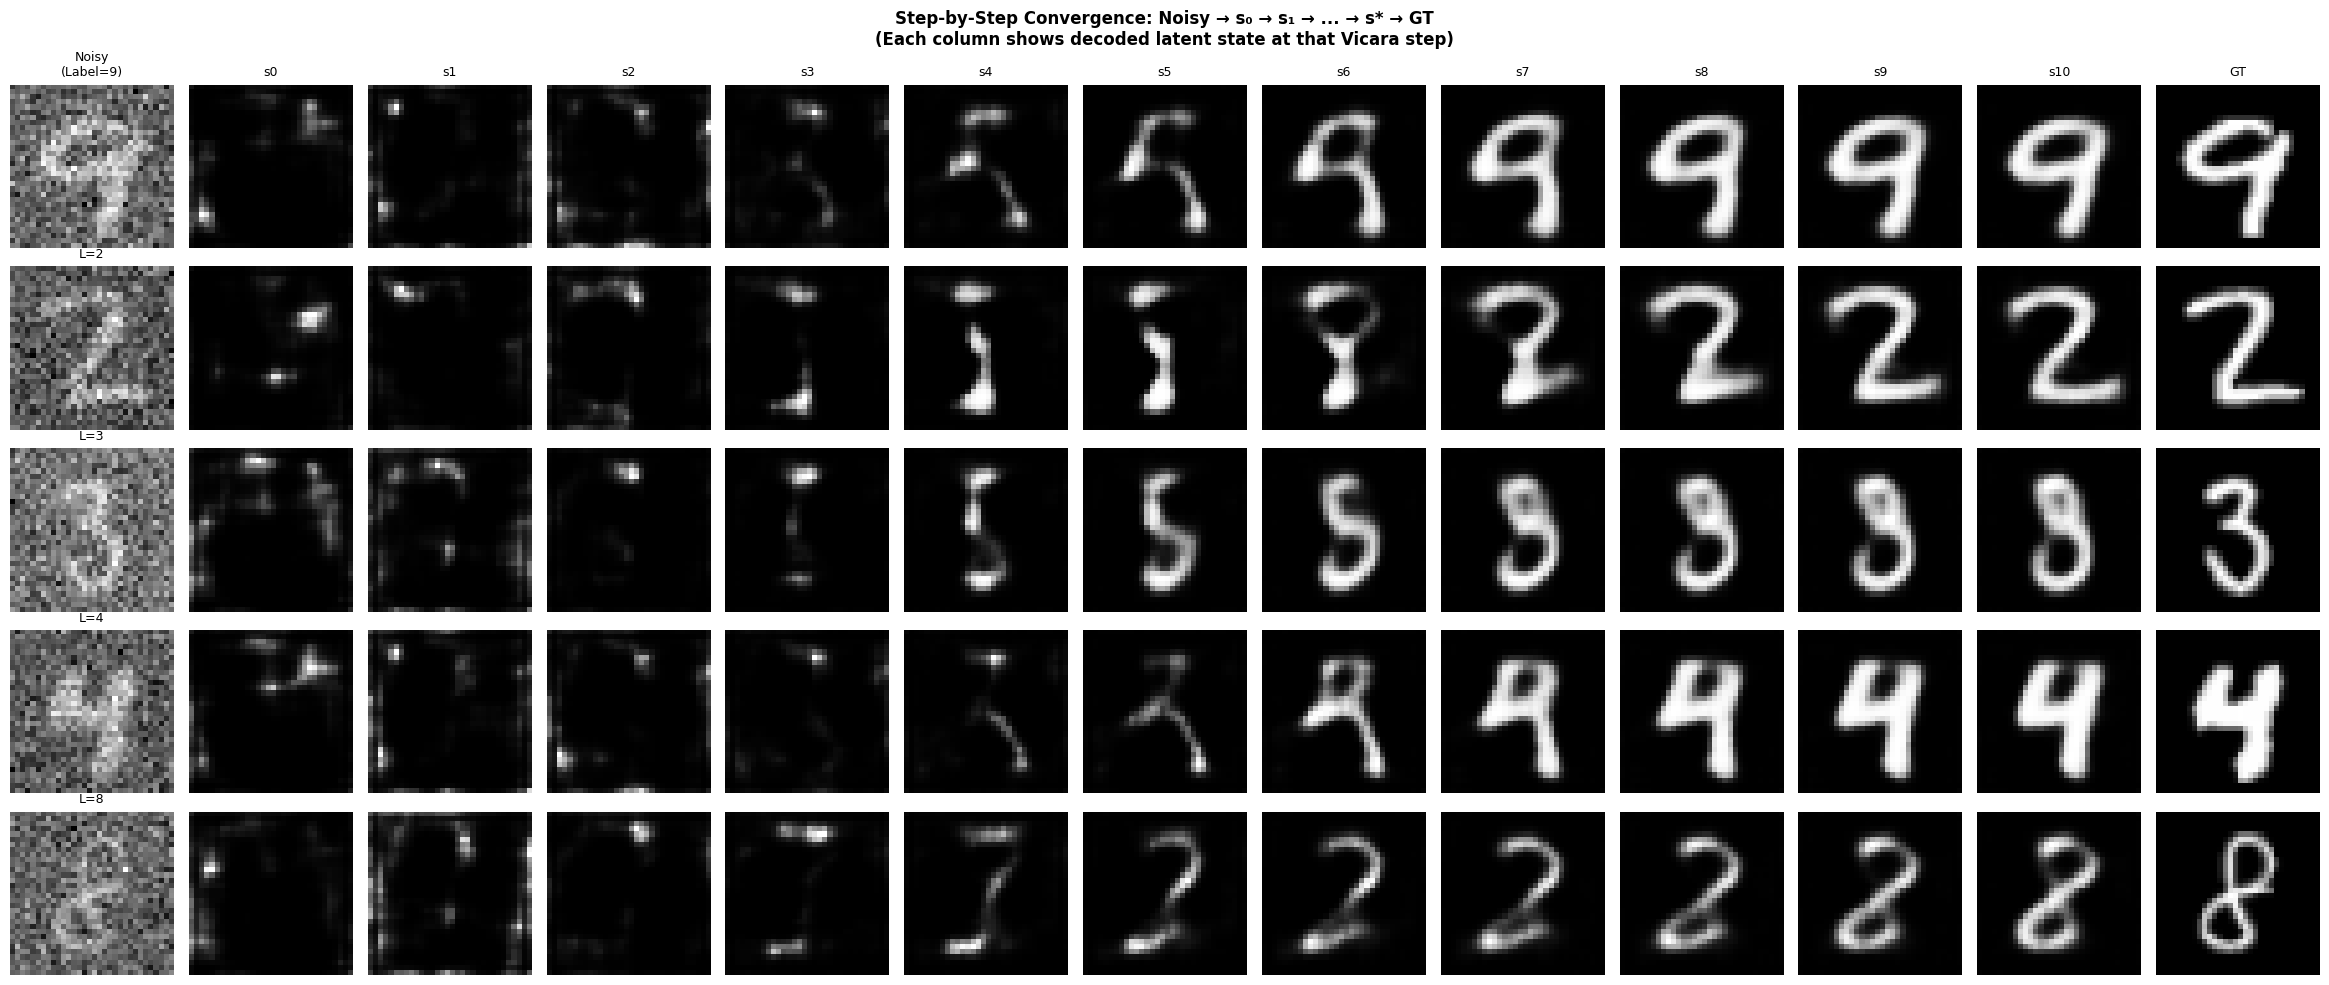

In [7]:
def visualize_step_by_step_convergence(system, test_loader, num_samples=4, noise_level=0.7):
    """
    Visualize image reconstruction at each Vicara step.

    Shows: Noisy Input → s₀ → s₁ → s₂ → ... → s* (decoded at each step)
    """
    system.eval()

    samples = []
    for batch in test_loader:
        if len(samples) >= num_samples:
            break
        for i in range(min(batch["x"].size(0), num_samples - len(samples))):
            samples.append({
                "x": batch["x"][i],
                "label": batch["class_label"][i].item()
            })

    # Number of columns: noisy + each step + ground truth
    n_steps = MAX_STEPS + 1  # s0 to s_T
    n_cols = 2 + n_steps  # noisy + steps + ground truth

    fig, axes = plt.subplots(num_samples, n_cols, figsize=(n_cols * 1.8, num_samples * 2))

    for row, sample in enumerate(samples):
        x = sample["x"].unsqueeze(0).to(device)
        label = sample["label"]

        with torch.no_grad():
            # Run forward and get trajectory
            result = system(x, noise_level=noise_level)
            trajectory = result.santana.to_tensor()  # (steps, batch, dim)

            # Decode each step using samatha_recon_head
            step_images = []
            for step in range(trajectory.size(0)):
                s_t = trajectory[step, 0:1, :]  # (1, dim)
                img = system.samatha_recon_head(s_t)  # (1, C, H, W)
                step_images.append(img[0].cpu())

        # Noisy input
        noisy = x + torch.randn_like(x) * noise_level

        # Plot noisy input
        axes[row, 0].imshow(noisy[0].cpu().squeeze(), cmap="gray")
        axes[row, 0].set_title(f"Noisy\n(Label={label})" if row == 0 else f"L={label}", fontsize=9)
        axes[row, 0].axis("off")

        # Plot each step
        for step, img in enumerate(step_images):
            col = step + 1
            axes[row, col].imshow(img.squeeze(), cmap="gray")
            if row == 0:
                axes[row, col].set_title(f"s{step}", fontsize=9)
            axes[row, col].axis("off")

        # Fill remaining columns if trajectory is shorter than MAX_STEPS
        for col in range(len(step_images) + 1, n_cols - 1):
            axes[row, col].axis("off")

        # Ground truth
        axes[row, -1].imshow(x[0].cpu().squeeze(), cmap="gray")
        axes[row, -1].set_title("GT" if row == 0 else "", fontsize=9)
        axes[row, -1].axis("off")

    plt.suptitle("Step-by-Step Convergence: Noisy → s₀ → s₁ → ... → s* → GT\n"
                 "(Each column shows decoded latent state at that Vicara step)",
                 fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()


# Visualize step-by-step convergence
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)
visualize_step_by_step_convergence(system, test_loader, num_samples=5, noise_level=0.7)

## 8. Convergence Trajectory Analysis

SantanaLogを使って、収束過程のエネルギー変化を可視化します。

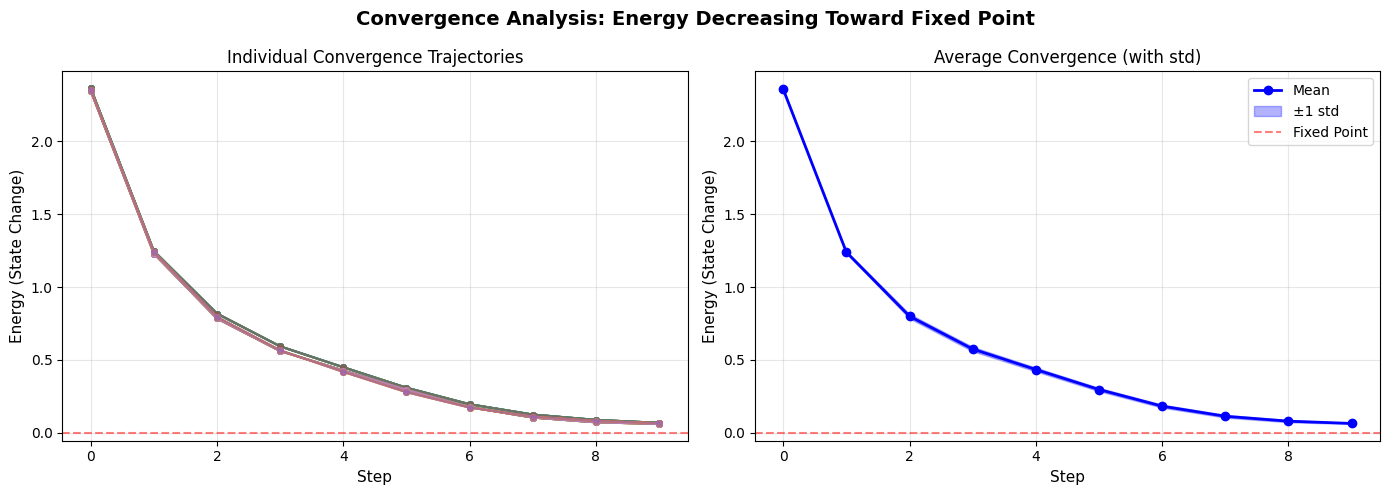

Average final energy: 0.0640
Average steps to converge: 10


In [8]:
def visualize_convergence_energy(system, test_loader, num_samples=5, noise_level=0.5):
    """
    Visualize energy decay during convergence for multiple samples.
    """
    system.eval()

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    all_energies = []
    all_labels = []

    samples_collected = 0
    for batch in test_loader:
        if samples_collected >= num_samples:
            break

        x = batch["x"].to(device)
        labels = batch["class_label"]

        with torch.no_grad():
            result = system(x, noise_level=noise_level)

        # Collect energies for each sample
        for i in range(min(x.size(0), num_samples - samples_collected)):
            all_energies.append(result.santana.energies)
            all_labels.append(labels[i].item())
            samples_collected += 1

    # Plot individual energy curves
    cmap = plt.cm.tab10
    for energies, label in zip(all_energies, all_labels):
        axes[0].plot(energies, '-o', color=cmap(label), alpha=0.7,
                     markersize=4, label=f'Digit {label}')

    axes[0].set_xlabel("Step", fontsize=11)
    axes[0].set_ylabel("Energy (State Change)", fontsize=11)
    axes[0].set_title("Individual Convergence Trajectories", fontsize=12)
    axes[0].grid(True, alpha=0.3)
    axes[0].axhline(y=0, color='r', linestyle='--', alpha=0.5)

    # Plot average energy
    max_len = max(len(e) for e in all_energies)
    padded = np.array([e + [e[-1]] * (max_len - len(e)) for e in all_energies])
    mean_energy = padded.mean(axis=0)
    std_energy = padded.std(axis=0)

    steps = np.arange(max_len)
    axes[1].plot(steps, mean_energy, 'b-o', linewidth=2, markersize=6, label='Mean')
    axes[1].fill_between(steps, mean_energy - std_energy, mean_energy + std_energy,
                          alpha=0.3, color='blue', label='±1 std')
    axes[1].set_xlabel("Step", fontsize=11)
    axes[1].set_ylabel("Energy (State Change)", fontsize=11)
    axes[1].set_title("Average Convergence (with std)", fontsize=12)
    axes[1].grid(True, alpha=0.3)
    axes[1].axhline(y=0, color='r', linestyle='--', alpha=0.5, label='Fixed Point')
    axes[1].legend()

    plt.suptitle("Convergence Analysis: Energy Decreasing Toward Fixed Point",
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print(f"Average final energy: {mean_energy[-1]:.4f}")
    print(f"Average steps to converge: {max_len}")


test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)
visualize_convergence_energy(system, test_loader, num_samples=20, noise_level=0.5)

## 9. Latent Space Trajectory (PCA)

複数のサンプルの軌跡を潜在空間で可視化し、アトラクタへの収束を確認します。

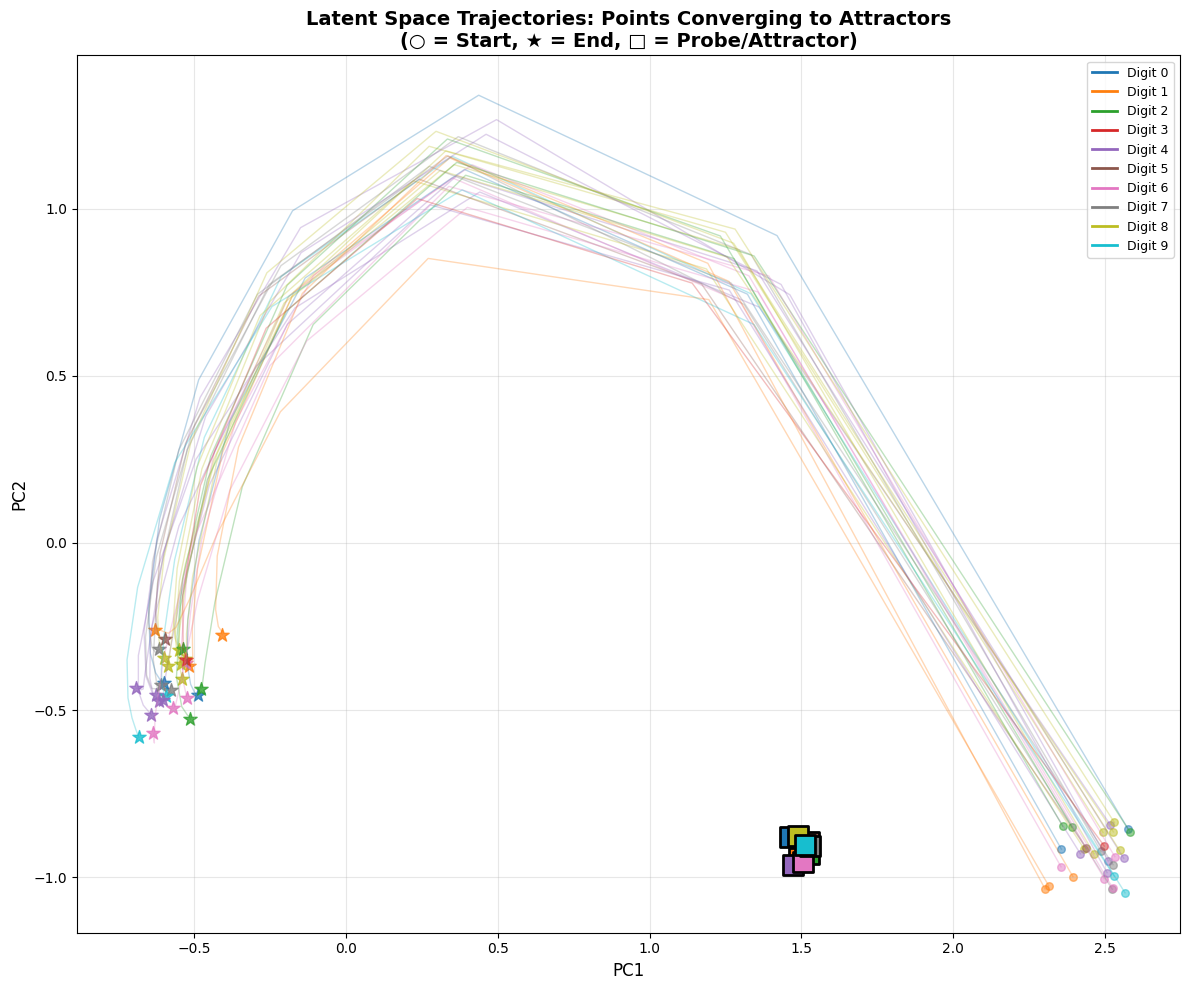

In [9]:
def visualize_latent_trajectories(system, test_loader, num_samples=20, noise_level=0.5):
    """
    Visualize multiple sample trajectories in 2D latent space using PCA.
    """
    system.eval()

    all_trajectories = []  # List of (num_steps, dim) arrays
    all_labels = []

    # Collect trajectories
    samples_collected = 0
    for batch in test_loader:
        if samples_collected >= num_samples:
            break

        x = batch["x"].to(device)
        labels = batch["class_label"]

        with torch.no_grad():
            result = system(x, noise_level=noise_level)
            trajectory = result.santana.to_tensor()  # (steps, batch, dim)

        # Extract per-sample trajectories
        for i in range(min(x.size(0), num_samples - samples_collected)):
            traj = trajectory[:, i, :].cpu().numpy()  # (steps, dim)
            all_trajectories.append(traj)
            all_labels.append(labels[i].item())
            samples_collected += 1

    # Stack all points for PCA
    all_points = np.concatenate(all_trajectories, axis=0)  # (total_points, dim)

    # Fit PCA
    pca = PCA(n_components=2)
    all_points_2d = pca.fit_transform(all_points)

    # Also project probes
    with torch.no_grad():
        probes = system.samatha.vitakka.probes.data.cpu().numpy()
    probes_2d = pca.transform(probes)

    # Split back into trajectories
    idx = 0
    trajectories_2d = []
    for traj in all_trajectories:
        n_steps = len(traj)
        traj_2d = all_points_2d[idx:idx + n_steps]
        trajectories_2d.append(traj_2d)
        idx += n_steps

    # Plot
    fig, ax = plt.subplots(figsize=(12, 10))

    # Color map for digits
    cmap = plt.cm.tab10

    # Plot trajectories
    for traj_2d, label in zip(trajectories_2d, all_labels):
        color = cmap(label)
        # Plot line
        ax.plot(traj_2d[:, 0], traj_2d[:, 1], '-', color=color, alpha=0.3, linewidth=1)
        # Mark start (circle) and end (star)
        ax.scatter(traj_2d[0, 0], traj_2d[0, 1], c=[color], marker='o', s=30, alpha=0.5)
        ax.scatter(traj_2d[-1, 0], traj_2d[-1, 1], c=[color], marker='*', s=100, alpha=0.8)

    # Plot probes (attractors)
    for i in range(len(probes_2d)):
        ax.scatter(probes_2d[i, 0], probes_2d[i, 1],
                   c=[cmap(i)], marker='s', s=200, edgecolors='black', linewidths=2,
                   zorder=10)
        ax.annotate(f'{i}', (probes_2d[i, 0], probes_2d[i, 1]),
                    fontsize=12, fontweight='bold', ha='center', va='center')

    ax.set_xlabel("PC1", fontsize=12)
    ax.set_ylabel("PC2", fontsize=12)
    ax.set_title("Latent Space Trajectories: Points Converging to Attractors\n"
                 "(○ = Start, ★ = End, □ = Probe/Attractor)",
                 fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)

    # Add legend for first few digits
    handles = [plt.Line2D([0], [0], color=cmap(i), linewidth=2, label=f'Digit {i}')
               for i in range(10)]
    ax.legend(handles=handles, loc='upper right', fontsize=9)

    plt.tight_layout()
    plt.show()

    return trajectories_2d, probes_2d


# Visualize trajectories
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)
trajectories_2d, probes_2d = visualize_latent_trajectories(system, test_loader, num_samples=30)

## 10. Learned Probes Analysis

学習後のプローブ（概念アトラクタ）がどのような「概念」を表しているかを可視化します。

**Key Questions:**
- 各プローブはどの数字を表しているか？
- プローブは学習でどう変化したか？
- どのプローブが多く使われているか？

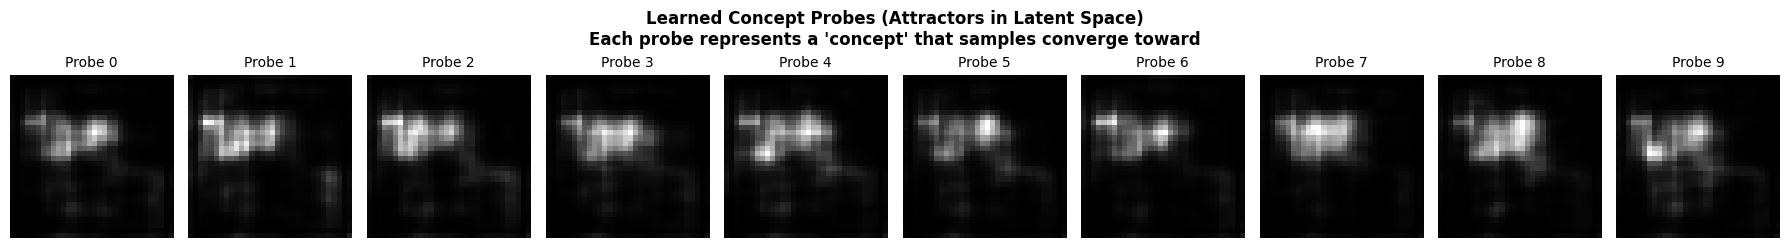

In [10]:
def visualize_learned_probes(system):
    """
    Visualize what each learned probe represents by decoding it.
    """
    system.eval()

    with torch.no_grad():
        # Get current probes
        probes = system.samatha.vitakka.probes.data  # (N_PROBES, dim)

        # Decode probes using samatha_recon_head
        decoded_probes = system.samatha_recon_head(probes)  # (N_PROBES, C, H, W)

    fig, axes = plt.subplots(1, N_PROBES, figsize=(N_PROBES * 1.8, 2.5))

    for i in range(N_PROBES):
        axes[i].imshow(decoded_probes[i].cpu().squeeze(), cmap="gray")
        axes[i].set_title(f"Probe {i}", fontsize=10)
        axes[i].axis("off")

    plt.suptitle("Learned Concept Probes (Attractors in Latent Space)\n"
                 "Each probe represents a 'concept' that samples converge toward",
                 fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

    return decoded_probes


# Visualize learned probes
decoded_probes = visualize_learned_probes(system)

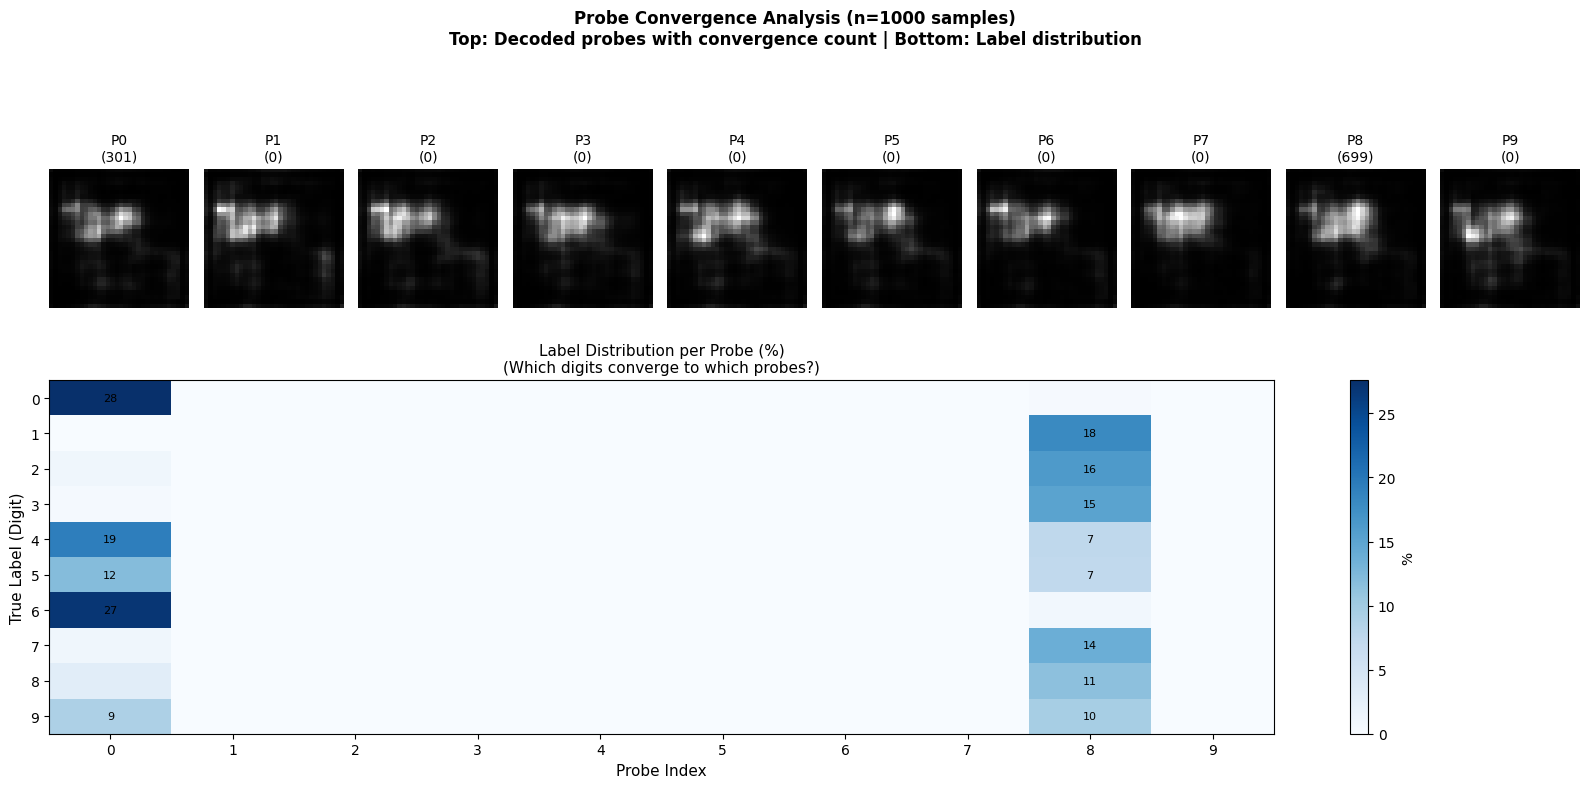


--- Probe Convergence Summary ---
Probe 0:  301 samples, dominant label = 0 (27.6%)
Probe 1:    0 samples, dominant label = 0 (0.0%)
Probe 2:    0 samples, dominant label = 0 (0.0%)
Probe 3:    0 samples, dominant label = 0 (0.0%)
Probe 4:    0 samples, dominant label = 0 (0.0%)
Probe 5:    0 samples, dominant label = 0 (0.0%)
Probe 6:    0 samples, dominant label = 0 (0.0%)
Probe 7:    0 samples, dominant label = 0 (0.0%)
Probe 8:  699 samples, dominant label = 1 (18.0%)
Probe 9:    0 samples, dominant label = 0 (0.0%)


In [11]:
def analyze_probe_convergence(system, test_loader, num_samples=500):
    """
    Analyze which probe each sample converges to and count statistics.

    Returns:
        probe_counts: Count of samples converging to each probe
        probe_label_matrix: (N_PROBES, 10) matrix showing label distribution per probe
    """
    system.eval()

    probe_assignments = []  # Which probe each sample converged to
    true_labels = []

    samples_collected = 0
    for batch in test_loader:
        if samples_collected >= num_samples:
            break

        x = batch["x"].to(device)
        labels = batch["class_label"]

        with torch.no_grad():
            # Get s* (converged state)
            result = system(x, noise_level=0.0)  # No noise for clean analysis
            s_star = result.s_star  # (batch, dim)

            # Get probes
            probes = system.samatha.vitakka.probes.data  # (N_PROBES, dim)

            # Find nearest probe for each sample (cosine similarity)
            s_star_norm = s_star / (s_star.norm(dim=1, keepdim=True) + 1e-8)
            probes_norm = probes / (probes.norm(dim=1, keepdim=True) + 1e-8)
            similarities = torch.mm(s_star_norm, probes_norm.t())  # (batch, N_PROBES)
            nearest_probes = similarities.argmax(dim=1)  # (batch,)

        for i in range(x.size(0)):
            if samples_collected >= num_samples:
                break
            probe_assignments.append(nearest_probes[i].item())
            true_labels.append(labels[i].item())
            samples_collected += 1

    # Count statistics
    probe_counts = [0] * N_PROBES
    probe_label_matrix = np.zeros((N_PROBES, 10))

    for probe_idx, label in zip(probe_assignments, true_labels):
        probe_counts[probe_idx] += 1
        if label < 10:
            probe_label_matrix[probe_idx, label] += 1

    return probe_counts, probe_label_matrix, probe_assignments, true_labels


def visualize_probe_statistics(system, test_loader, num_samples=1000):
    """
    Visualize probe convergence statistics with decoded probe images.
    """
    probe_counts, probe_label_matrix, _, _ = analyze_probe_convergence(
        system, test_loader, num_samples
    )

    # Get decoded probes
    with torch.no_grad():
        probes = system.samatha.vitakka.probes.data
        decoded_probes = system.samatha_recon_head(probes)

    fig = plt.figure(figsize=(16, 8))

    # Top row: Decoded probes with count
    for i in range(N_PROBES):
        ax = fig.add_subplot(2, N_PROBES, i + 1)
        ax.imshow(decoded_probes[i].cpu().squeeze(), cmap="gray")
        ax.set_title(f"P{i}\n({probe_counts[i]})", fontsize=10)
        ax.axis("off")

    # Bottom: Heatmap of label distribution per probe
    ax_heatmap = fig.add_subplot(2, 1, 2)

    # Normalize by probe (show percentage of each label within each probe)
    probe_label_pct = probe_label_matrix / (probe_label_matrix.sum(axis=1, keepdims=True) + 1e-8) * 100

    im = ax_heatmap.imshow(probe_label_pct.T, cmap="Blues", aspect="auto")
    ax_heatmap.set_xlabel("Probe Index", fontsize=11)
    ax_heatmap.set_ylabel("True Label (Digit)", fontsize=11)
    ax_heatmap.set_xticks(range(N_PROBES))
    ax_heatmap.set_yticks(range(10))
    ax_heatmap.set_title("Label Distribution per Probe (%)\n"
                         "(Which digits converge to which probes?)", fontsize=11)

    # Add text annotations
    for i in range(N_PROBES):
        for j in range(10):
            val = probe_label_pct[i, j]
            if val > 5:  # Only show significant values
                ax_heatmap.text(i, j, f"{val:.0f}", ha="center", va="center",
                               fontsize=8, color="white" if val > 50 else "black")

    plt.colorbar(im, ax=ax_heatmap, label="%")

    plt.suptitle(f"Probe Convergence Analysis (n={num_samples} samples)\n"
                 "Top: Decoded probes with convergence count | Bottom: Label distribution",
                 fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Print summary
    print("\n--- Probe Convergence Summary ---")
    for i in range(N_PROBES):
        dominant_label = probe_label_matrix[i].argmax()
        dominant_pct = probe_label_pct[i, dominant_label]
        print(f"Probe {i}: {probe_counts[i]:4d} samples, dominant label = {dominant_label} ({dominant_pct:.1f}%)")


# Run probe analysis
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
visualize_probe_statistics(system, test_loader, num_samples=1000)

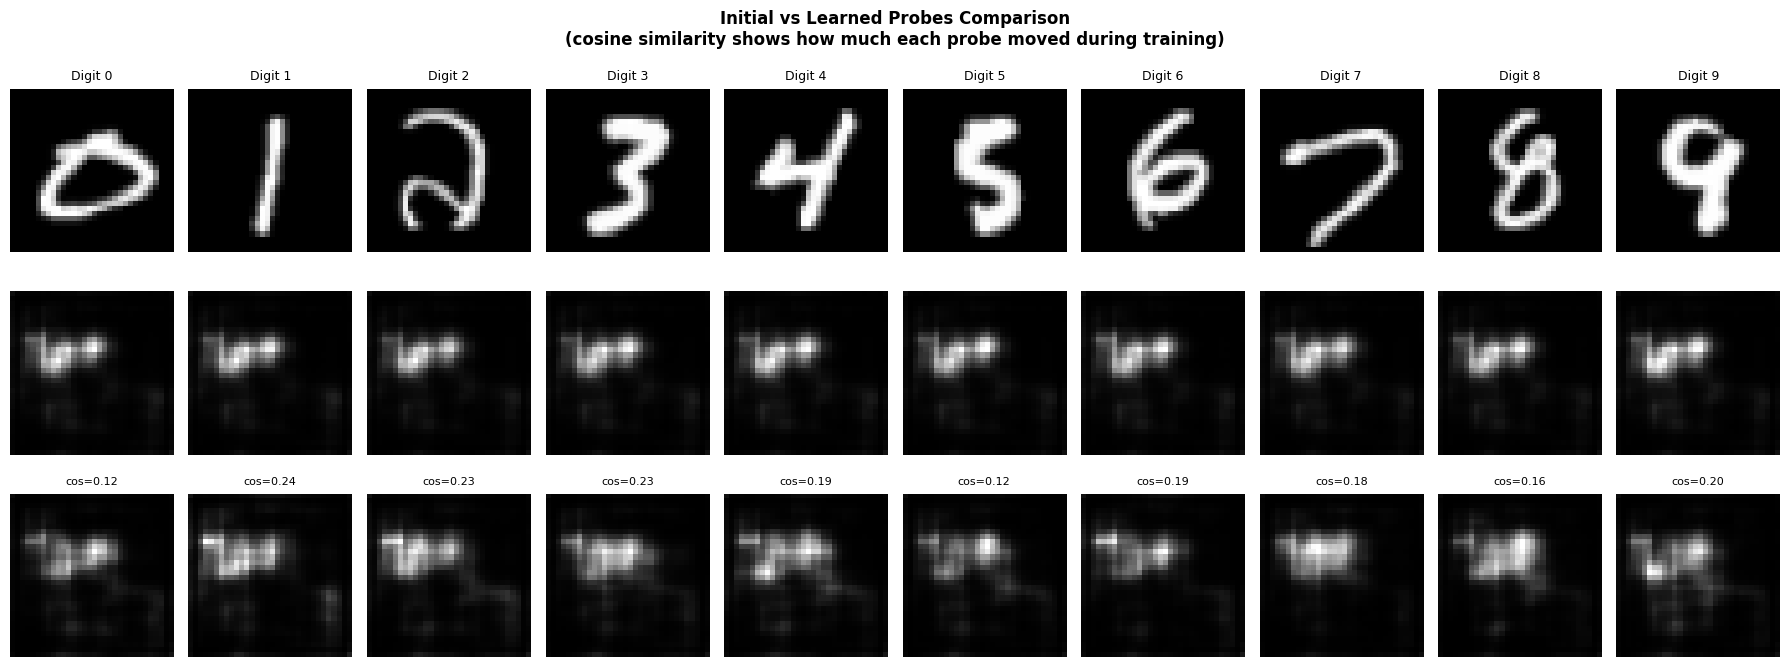


--- Probe Change Statistics ---
Average L2 distance: 0.3066
Average cosine similarity: 0.1865
Min cosine similarity: 0.1222 (Probe 0)
Max cosine similarity: 0.2379 (Probe 1)


In [12]:
def compare_initial_vs_learned_probes(system, initial_probes, initial_rep_images):
    """
    Compare initial probes with learned probes after training.
    """
    system.eval()

    with torch.no_grad():
        # Get current (learned) probes
        learned_probes = system.samatha.vitakka.probes.data  # (N_PROBES, dim)

        # Decode both using samatha_recon_head
        decoded_initial = system.samatha_recon_head(initial_probes)
        decoded_learned = system.samatha_recon_head(learned_probes)

        # Compute distance between initial and learned probes
        distances = (learned_probes - initial_probes).norm(dim=1)

        # Compute cosine similarity
        initial_norm = initial_probes / (initial_probes.norm(dim=1, keepdim=True) + 1e-8)
        learned_norm = learned_probes / (learned_probes.norm(dim=1, keepdim=True) + 1e-8)
        cosine_sim = (initial_norm * learned_norm).sum(dim=1)

    fig, axes = plt.subplots(3, N_PROBES, figsize=(N_PROBES * 1.8, 7))

    # Row 0: Original representative images
    for i in range(N_PROBES):
        axes[0, i].imshow(initial_rep_images[i].cpu().squeeze(), cmap="gray")
        axes[0, i].set_title(f"Digit {i}", fontsize=9)
        axes[0, i].axis("off")
    axes[0, 0].set_ylabel("Original\nImages", fontsize=10, rotation=0, ha='right', va='center')

    # Row 1: Initial probes (decoded)
    for i in range(N_PROBES):
        axes[1, i].imshow(decoded_initial[i].cpu().squeeze(), cmap="gray")
        axes[1, i].axis("off")
    axes[1, 0].set_ylabel("Initial\nProbes", fontsize=10, rotation=0, ha='right', va='center')

    # Row 2: Learned probes (decoded)
    for i in range(N_PROBES):
        axes[2, i].imshow(decoded_learned[i].cpu().squeeze(), cmap="gray")
        axes[2, i].set_title(f"cos={cosine_sim[i]:.2f}", fontsize=8)
        axes[2, i].axis("off")
    axes[2, 0].set_ylabel("Learned\nProbes", fontsize=10, rotation=0, ha='right', va='center')

    plt.suptitle("Initial vs Learned Probes Comparison\n"
                 "(cosine similarity shows how much each probe moved during training)",
                 fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Print statistics
    print("\n--- Probe Change Statistics ---")
    print(f"Average L2 distance: {distances.mean():.4f}")
    print(f"Average cosine similarity: {cosine_sim.mean():.4f}")
    print(f"Min cosine similarity: {cosine_sim.min():.4f} (Probe {cosine_sim.argmin().item()})")
    print(f"Max cosine similarity: {cosine_sim.max():.4f} (Probe {cosine_sim.argmax().item()})")


# Compare initial vs learned probes
compare_initial_vs_learned_probes(system, initial_probes, initial_rep_images)

## 11. Quantitative Evaluation

定量的な評価指標を算出します：
- **再構成品質**: MSE, PSNR, SSIM
- **収束率**: エネルギー閾値以下で収束した割合
- **ベースライン比較**: 単純なAutoencoderとの比較

In [13]:
def compute_psnr(mse: float, max_val: float = 2.0) -> float:
    """Compute PSNR from MSE. max_val=2.0 for [-1,1] normalized images."""
    if mse == 0:
        return float('inf')
    return 10 * np.log10(max_val ** 2 / mse)


def compute_ssim(img1: torch.Tensor, img2: torch.Tensor, window_size: int = 11) -> float:
    """
    Compute SSIM between two images.
    Simplified implementation for grayscale images.
    """
    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    # Convert to numpy
    img1 = img1.cpu().numpy().squeeze()
    img2 = img2.cpu().numpy().squeeze()

    mu1 = img1.mean()
    mu2 = img2.mean()
    sigma1_sq = img1.var()
    sigma2_sq = img2.var()
    sigma12 = ((img1 - mu1) * (img2 - mu2)).mean()

    ssim = ((2 * mu1 * mu2 + C1) * (2 * sigma12 + C2)) / \
           ((mu1 ** 2 + mu2 ** 2 + C1) * (sigma1_sq + sigma2_sq + C2))
    return ssim


def evaluate_reconstruction_quality(system, test_loader, num_samples=500, noise_level=0.5):
    """
    Evaluate reconstruction quality with MSE, PSNR, SSIM.
    """
    system.eval()

    mse_list = []
    psnr_list = []
    ssim_list = []

    samples_collected = 0
    for batch in test_loader:
        if samples_collected >= num_samples:
            break

        x = batch["x"].to(device)
        batch_size = x.size(0)

        with torch.no_grad():
            result = system(x, noise_level=noise_level)
            x_recon = system.samatha_recon_head(result.s_star)

        for i in range(min(batch_size, num_samples - samples_collected)):
            mse = ((x[i] - x_recon[i]) ** 2).mean().item()
            psnr = compute_psnr(mse)
            ssim = compute_ssim(x[i], x_recon[i])

            mse_list.append(mse)
            psnr_list.append(psnr)
            ssim_list.append(ssim)
            samples_collected += 1

    return {
        "mse": {"mean": np.mean(mse_list), "std": np.std(mse_list), "values": mse_list},
        "psnr": {"mean": np.mean(psnr_list), "std": np.std(psnr_list), "values": psnr_list},
        "ssim": {"mean": np.mean(ssim_list), "std": np.std(ssim_list), "values": ssim_list},
    }


def evaluate_convergence_rate(system, test_loader, num_samples=500,
                               energy_threshold=0.1, noise_level=0.5):
    """
    Evaluate what percentage of samples converge below energy threshold.
    """
    system.eval()

    final_energies = []
    converged_count = 0

    samples_collected = 0
    for batch in test_loader:
        if samples_collected >= num_samples:
            break

        x = batch["x"].to(device)
        batch_size = x.size(0)

        with torch.no_grad():
            result = system(x, noise_level=noise_level)

        for i in range(min(batch_size, num_samples - samples_collected)):
            final_energy = result.santana.energies[-1]
            final_energies.append(final_energy)
            if final_energy < energy_threshold:
                converged_count += 1
            samples_collected += 1

    convergence_rate = converged_count / len(final_energies) * 100

    return {
        "convergence_rate": convergence_rate,
        "threshold": energy_threshold,
        "mean_final_energy": np.mean(final_energies),
        "std_final_energy": np.std(final_energies),
        "final_energies": final_energies,
    }


# Evaluate Satipatthana
print("="*60)
print("Evaluating Satipatthana System...")
print("="*60)

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Reconstruction quality
recon_metrics = evaluate_reconstruction_quality(system, test_loader, num_samples=1000, noise_level=0.5)
print(f"\n--- Reconstruction Quality (noise_level=0.5) ---")
print(f"MSE:  {recon_metrics['mse']['mean']:.4f} ± {recon_metrics['mse']['std']:.4f}")
print(f"PSNR: {recon_metrics['psnr']['mean']:.2f} ± {recon_metrics['psnr']['std']:.2f} dB")
print(f"SSIM: {recon_metrics['ssim']['mean']:.4f} ± {recon_metrics['ssim']['std']:.4f}")

# Convergence rate
conv_metrics = evaluate_convergence_rate(system, test_loader, num_samples=1000,
                                          energy_threshold=0.1, noise_level=0.5)
print(f"\n--- Convergence Rate (threshold=0.1) ---")
print(f"Convergence Rate: {conv_metrics['convergence_rate']:.1f}%")
print(f"Mean Final Energy: {conv_metrics['mean_final_energy']:.4f} ± {conv_metrics['std_final_energy']:.4f}")

Evaluating Satipatthana System...

--- Reconstruction Quality (noise_level=0.5) ---
MSE:  0.0521 ± 0.0239
PSNR: 19.31 ± 2.03 dB
SSIM: 0.8999 ± 0.0534

--- Convergence Rate (threshold=0.1) ---
Convergence Rate: 100.0%
Mean Final Energy: 0.0657 ± 0.0018


## Summary

このNotebookでは、Satipatthana Frameworkの**Samatha収束プロセス**と**概念プローブの学習**を可視化しました。

### Training (Stage 0 + Stage 1 のみ)
- **Stage 0**: Adapter Pre-training - 画像→潜在空間の変換を学習
- **Stage 1**: Samatha Training - 収束する固定点 + samatha_recon_head を学習

**Note:** Stage 2 (Vipassana) と Stage 3 (Decoder) はこのNotebookの目的（Samatha収束の可視化）には不要なためスキップしています。

### Key Visualizations
- **Step-by-Step Convergence**: 各Vicaraステップでの画像推移（s₀→s₁→...→s*）
- **Energy Decay**: エネルギー（状態変化量）が減少し、固定点に近づく過程
- **Latent Trajectories**: PCAで可視化した軌跡がアトラクタに収束
- **Learned Probes**: 学習後のプローブが表す「概念」
- **Probe Statistics**: どのプローブにどの数字が収束したかの統計
- **Initial vs Learned**: プローブが学習でどう変化したか

### Key Insights
- **Banachの不動点定理**に基づく収束が視覚的に確認できる
- **概念プローブ**は学習により移動し、最終的な「アトラクタ」となる
- **SantanaLog**により思考の軌跡が完全に記録・解析可能
- プローブと実際の数字の対応関係から、モデルの「概念理解」が確認できる

---

**Next:** [02_trust_score_explained.ipynb](02_trust_score_explained.ipynb) - Trust Scoreによる「知っている」と「知らない」の区別（Stage 2/3 を使用）